refer to code created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

# Time Series Classification with mWDN-Dataset LSST


multilevel Wavelet Decomposition Network (mWDN)

论文

Jingyuan Wang, Ze Wang, Jianfeng Li, and Junjie Wu. 2018. Multilevel Wavelet Decomposition Network for Interpretable Time Series Analysis. In Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (KDD '18). Association for Computing Machinery, New York, NY, USA, 2437–2446. https://doi.org/10.1145/3219819.3220060

Multilevel Wavelet Decomposition Network (mWDN) 是一种用来处理和分析复杂时序数据的强大工具。其可以应对以下几个问题：

多尺度特征提取：mWDN 通过小波分解能够在多个尺度上提取时序数据的特征，使得模型可以识别数据中的局部和全局模式。

降噪能力：通过小波分解，mWDN 能够有效地滤除时序数据中的噪声，从而提高数据的信号质量。

非平稳信号处理：时序数据往往是非平稳的，小波分解提供了一种自然的方式来处理这种数据，通过将信号分解到不同的频率带中，mWDN 可以捕捉到时间序列的动态变化。

提高预测性能：通过结合多尺度的信息，mWDN 可以改善传统预测模型的性能。

# Import libraries 📚

In [1]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [2]:
from tsai.all import *
computer_setup()

os              : macOS-15.3-arm64-arm-64bit
python          : 3.12.9
tsai            : 0.3.9
fastai          : 2.7.18
fastcore        : 1.7.29
torch           : 2.2.2
device          : mps
cpu cores       : 8
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A


# Load data 🔢

In [3]:
#dsid = 'FaceDetection' 
dsid = 'LSST'
X, y, splits = get_UCR_data(dsid, return_split=False)
print(X.shape, y.shape)

(4925, 6, 36) (4925,)


We can see that even if valid loss goes up, the model doesn't overfit as there's no drop in performance.

* In general, transformers require a lower lr compared to other time series models when used with the same datasets. It's important to use `learn.lr_find()` to learn what a good lr may be. 

* The paper authors recommend to standardize data by feature. This can be done by adding `TSStandardize(by_var=True` as a batch_tfm when creating the `TSDataLoaders`.

* When using TST with a long time series, you may use `max_w_len` to reduce the memory size and thus avoid gpu issues.`

* I've tried different types of positional encoders. In my experience, the default one works just fine.

* In some of the cases I've used it, you may need to increase the dropout > .1 and/ or fc_dropout > 0 in order to achieve a good performance. 

* You may also experiment with other key hyperparameters like d_model, n_layers, n_heads, etc, but I have not seen major difference in my experience. 

# mWDN baseline 🧢

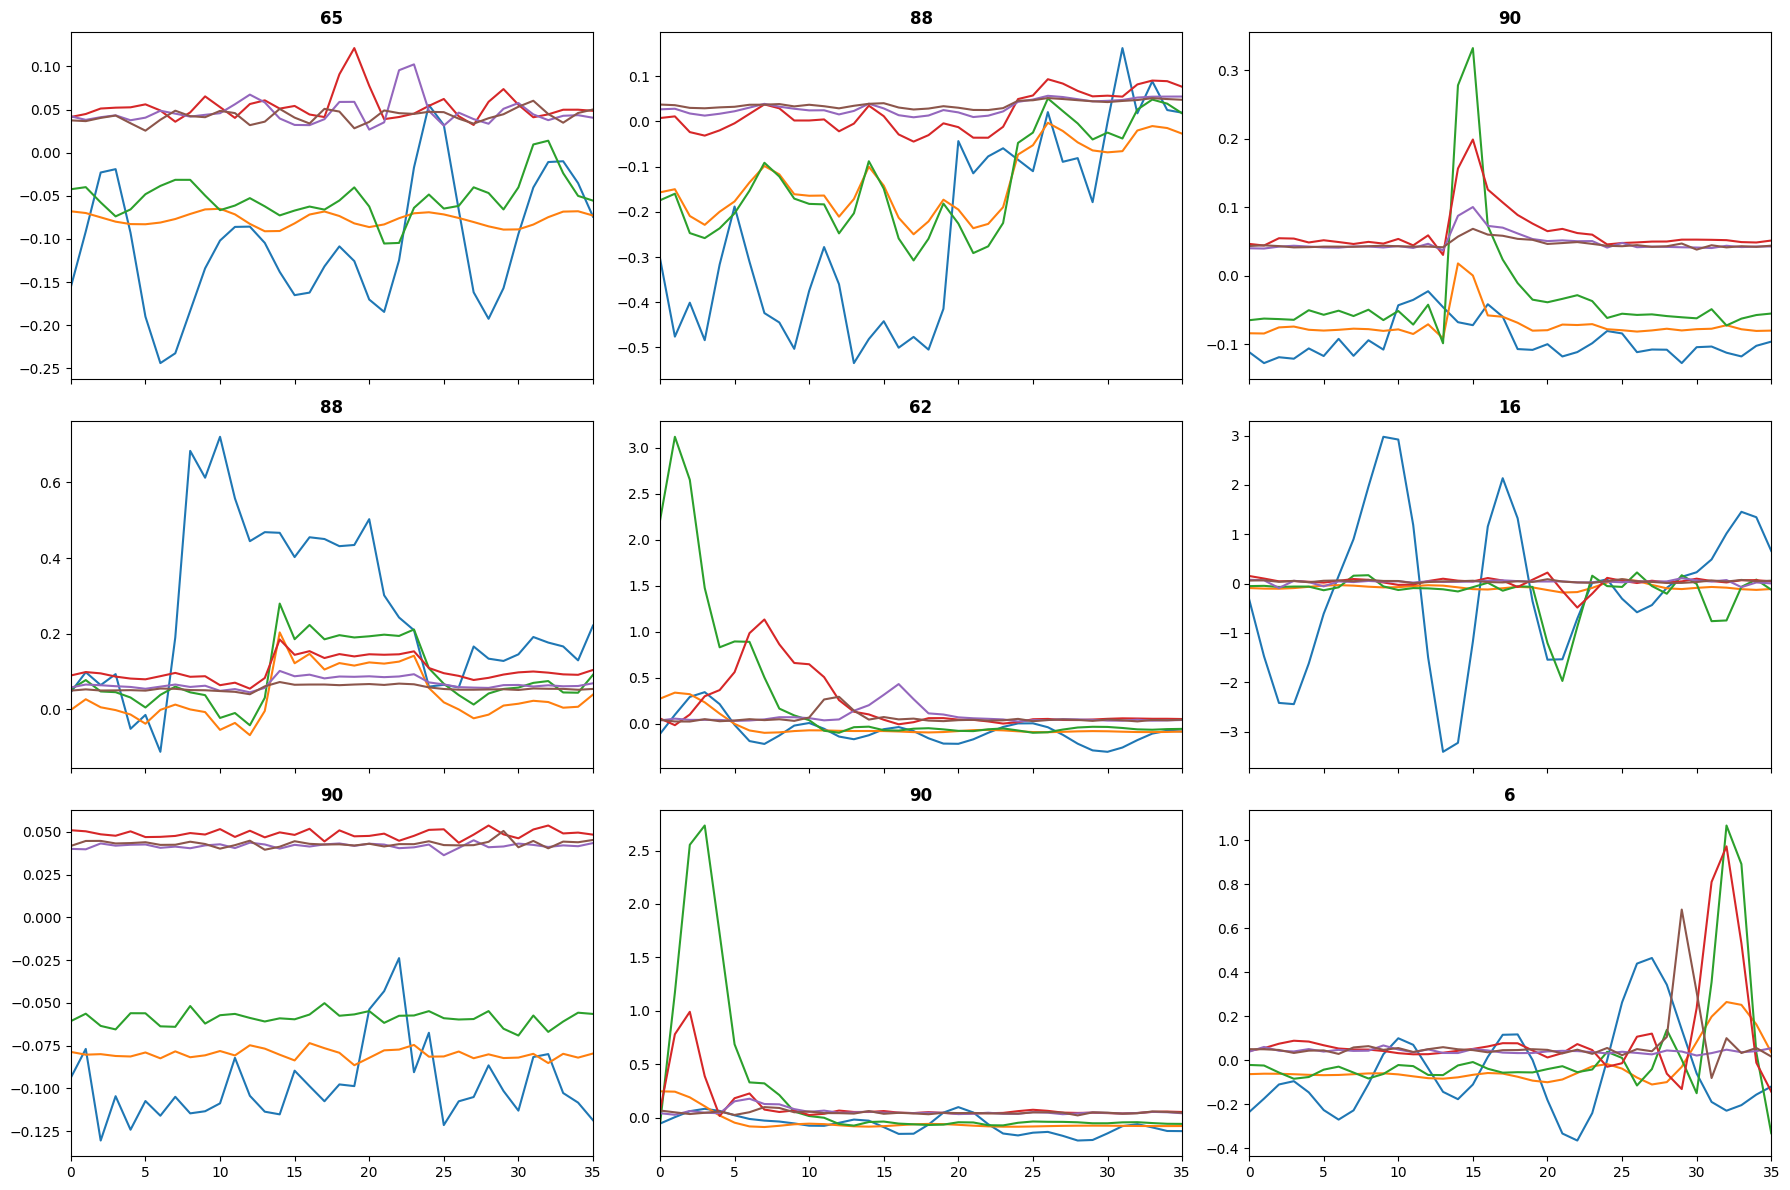

In [4]:
bs = 64
n_epochs = 100
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize(by_var=True))
dls.show_batch()

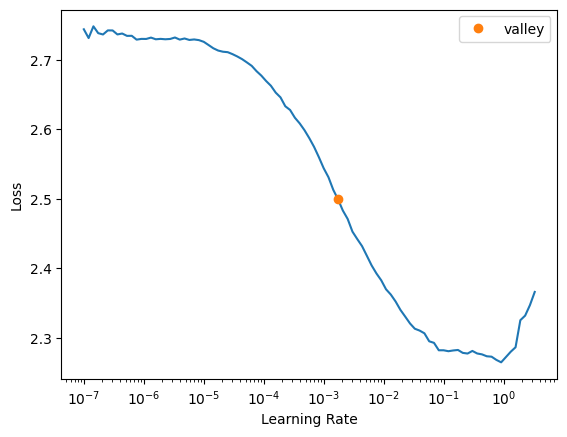

In [5]:
model = mWDN(dls.vars, dls.c, dls.len)

#learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy,RocAuc()],  cbs=ShowGraphCallback2())
sr=learn.lr_find()



epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,2.401855,2.516388,0.317518,0.632681,00:01
1,2.209500,2.073661,0.409570,0.729377,00:01
2,2.047506,1.917445,0.463098,0.792169,00:01
3,1.911043,2.029752,0.437551,0.771762,00:01
4,1.802482,1.841589,0.481752,0.812441,00:01
5,1.715407,4.423590,0.171127,0.695755,00:01
6,1.656419,2.046195,0.355637,0.832485,00:01
7,1.602948,2.543458,0.232360,0.766927,00:01
8,1.559329,3.417459,0.094891,0.695704,00:01
9,1.518322,2.377975,0.278589,0.764752,00:01


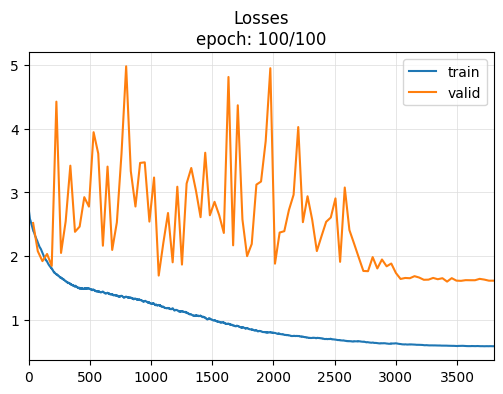

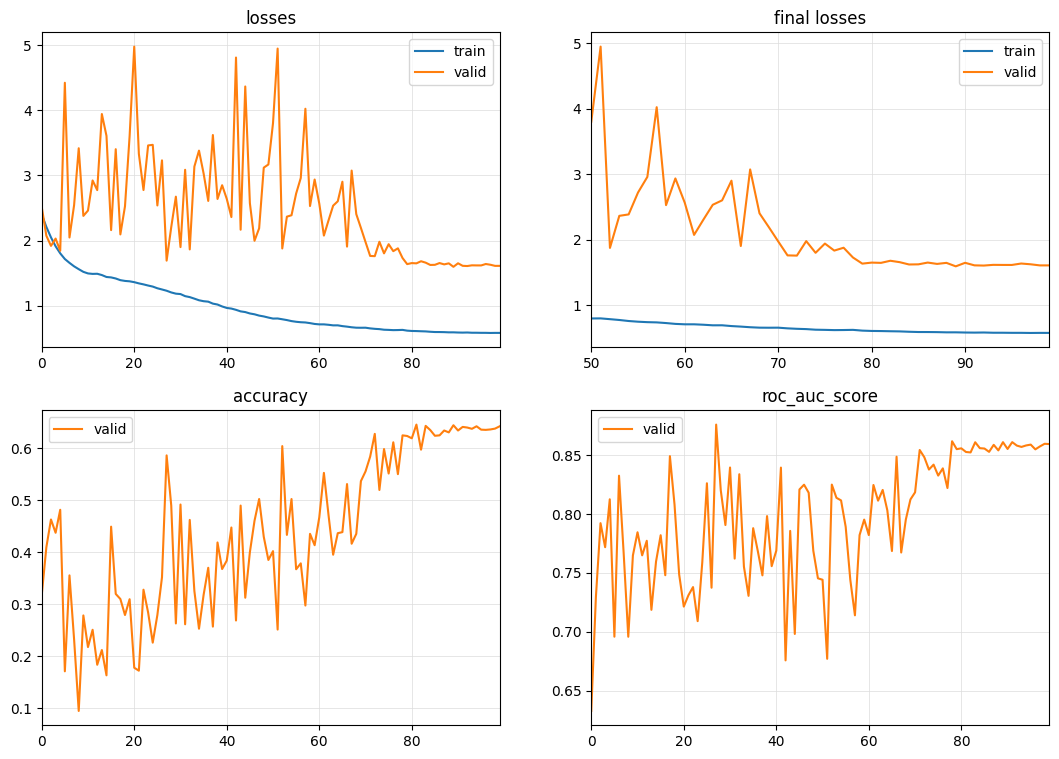


Elapsed time: 185.98068594932556


In [6]:
model = mWDN(dls.vars, dls.c, dls.len)
#learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy,RocAuc()],  cbs=ShowGraphCallback2())

start = time.time()
learn.fit_one_cycle(n_epochs, sr.valley)
print('\nElapsed time:', time.time() - start)
#learn.plot_metrics()

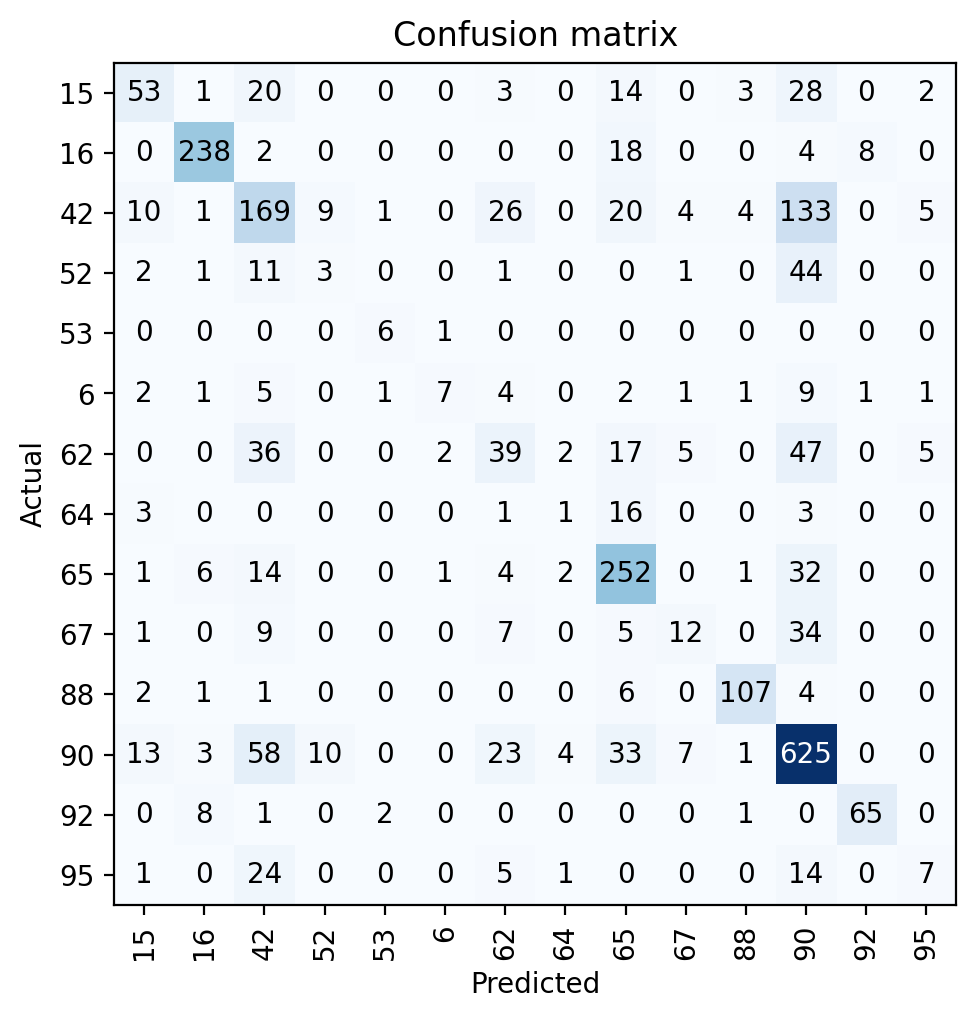

In [7]:
learn.plot_confusion_matrix(figsize=(5,5),dpi=200)

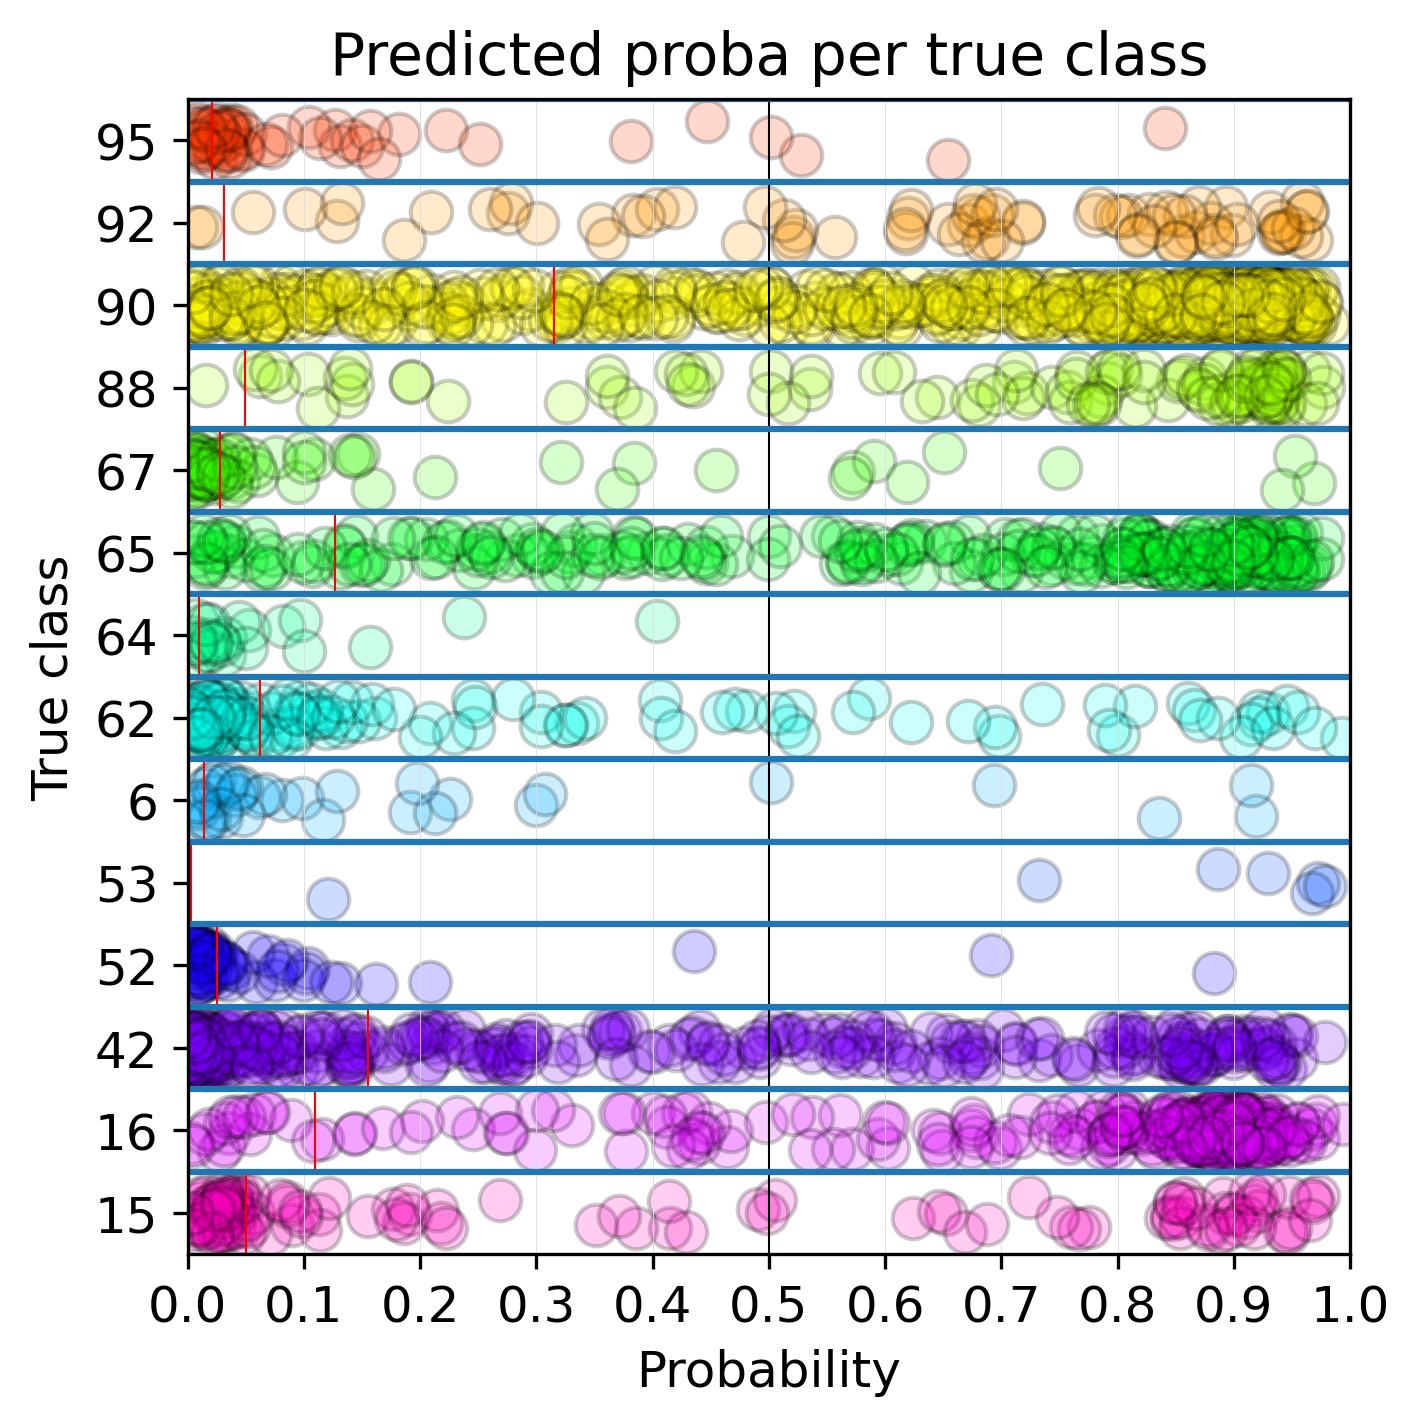

In [8]:
learn.show_probas(figsize=(5,5),dpi=300)

X.shape: (2459, 6, 36)
y.shape: (2459,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.998373


  0 feature: var_0                accuracy: 0.408296


  1 feature: var_1                accuracy: 0.304595


  2 feature: var_2                accuracy: 0.230582


  3 feature: var_3                accuracy: 0.390809


  4 feature: var_4                accuracy: 0.565677


  5 feature: var_5                accuracy: 0.644978



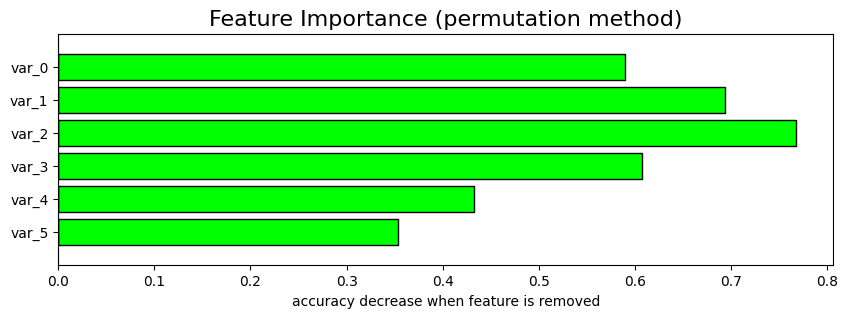

,Feature,accuracy,accuracy_change
0,var_2,0.230582,0.767792
1,var_1,0.304595,0.693778
2,var_3,0.390809,0.607564
3,var_0,0.408296,0.590077
4,var_4,0.565677,0.432696
5,var_5,0.644978,0.353396
6,BASELINE,0.998373,-0.000000


In [9]:
learn.feature_importance()

# How to improve performance with mWDN? ➕

The model clearly overfits in this task. To try and improve performance I will increase dropout. There are 2 types of dropout in TST: 

* applied to the MHAttention and Feed-Forward layers. Usually 0-0.3. Default: 0.1.

* applied to the fully connected head. Usually 0-0.8. Default: 0.

Let's see what's the impact of these 2 hyperparameters, used independently and combined.

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,2.329579,2.581018,0.495536,0.173155,00:02
1,2.288281,2.527141,0.551011,0.312247,00:02
2,2.263321,2.497008,0.593379,0.244931,00:02
3,2.228010,2.419801,0.635006,0.217356,00:02
4,2.189168,2.322015,0.673515,0.377940,00:02
5,2.142197,2.247524,0.691701,0.379157,00:02
6,2.104105,2.191652,0.718164,0.399027,00:02
7,2.066806,2.127851,0.741615,0.402676,00:02
8,2.024145,2.051771,0.746594,0.420925,00:02
9,1.991772,2.369851,0.709979,0.231955,00:02


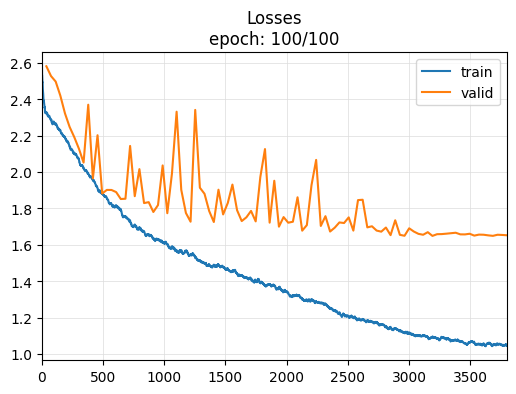

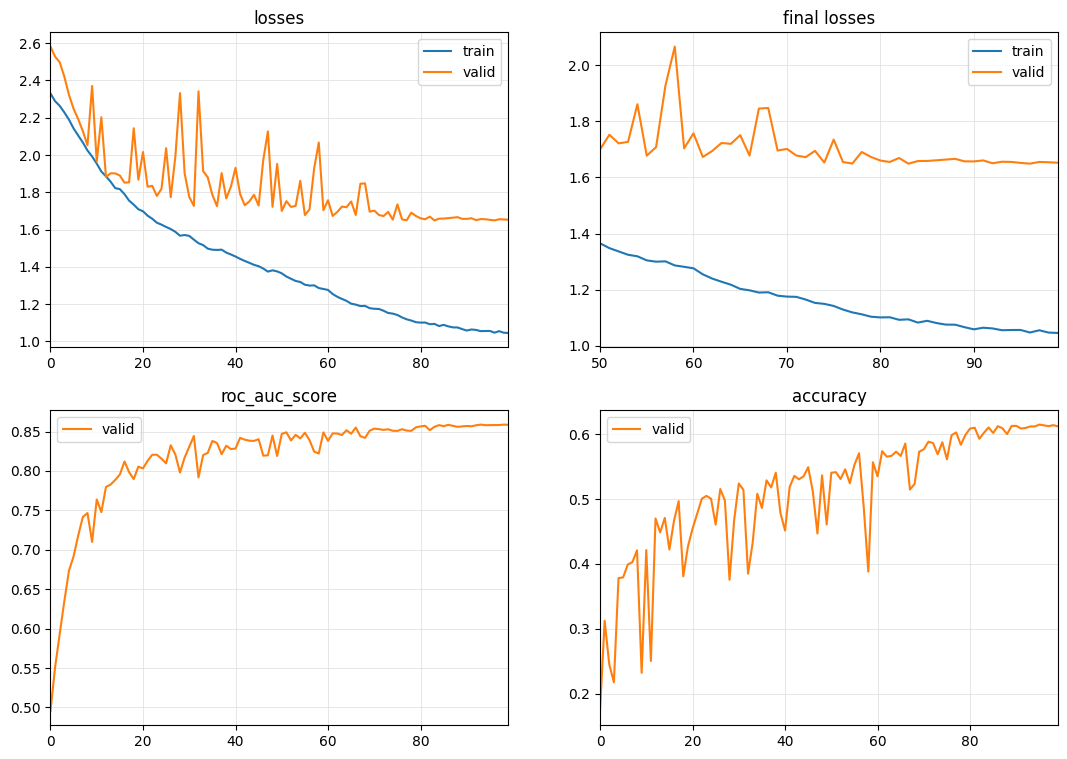


Elapsed time: 239.02813005447388


In [10]:
model = mWDNPlus(dls.vars, dls.c, dls.len, base_arch=TSTPlus, dropout=.3)
#learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(n_epochs, sr.valley)
print('\nElapsed time:', time.time() - start)
beep()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,2.609017,2.598615,0.471514,0.314274,00:02
1,2.549736,2.557489,0.524335,0.313058,00:02
2,2.500632,2.532170,0.565875,0.332928,00:02
3,2.470373,2.484023,0.593181,0.346310,00:02
4,2.451463,2.464186,0.605351,0.351987,00:02
5,2.427885,2.376241,0.652335,0.357664,00:02
6,2.373213,2.300333,0.667768,0.358881,00:02
7,2.316230,2.168824,0.681646,0.363747,00:02
8,2.293203,2.130825,0.707808,0.367802,00:02
9,2.275146,2.208524,0.720468,0.360908,00:02


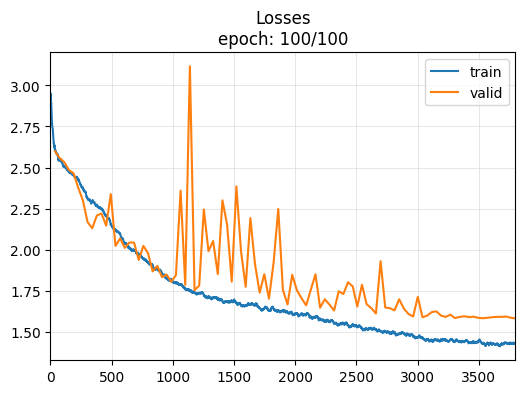

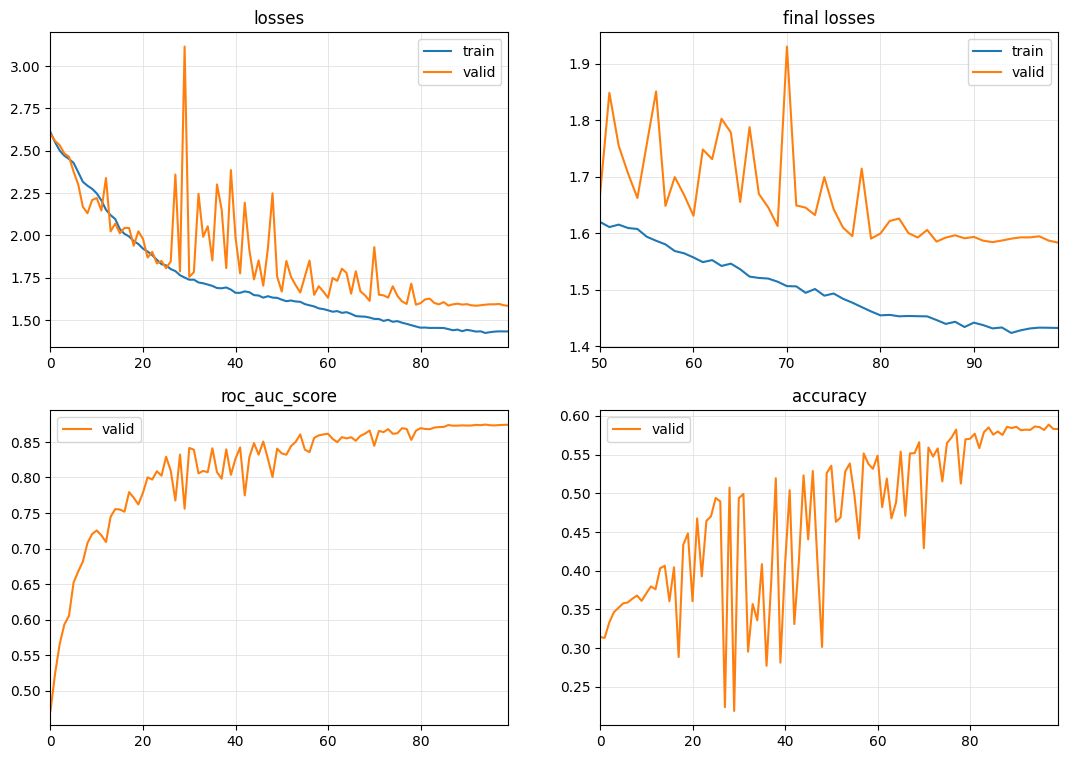


Elapsed time: 240.04442524909973


In [11]:
model = mWDNPlus(dls.vars, dls.c, dls.len, base_arch=TSTPlus, dropout=.3, fc_dropout=.8)
#learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(n_epochs, sr.valley)
print('\nElapsed time:', time.time() - start)
beep()

Let's check what happens if we increase dropout a bit more...

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,2.964009,2.582415,0.484413,0.300487,00:02
1,2.840393,2.542838,0.512996,0.311841,00:02
2,2.766794,2.532020,0.539922,0.241687,00:02
3,2.720526,2.518198,0.561159,0.176805,00:02
4,2.686023,2.519895,0.589320,0.334144,00:02
5,2.639864,2.490020,0.604044,0.354420,00:02
6,2.599908,2.399665,0.609282,0.346310,00:02
7,2.559151,2.230781,0.625753,0.353204,00:02
8,2.501047,2.272784,0.650099,0.364964,00:02
9,2.477888,2.187533,0.676697,0.355231,00:02


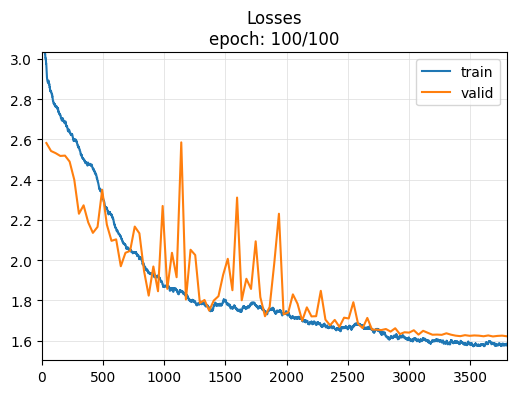

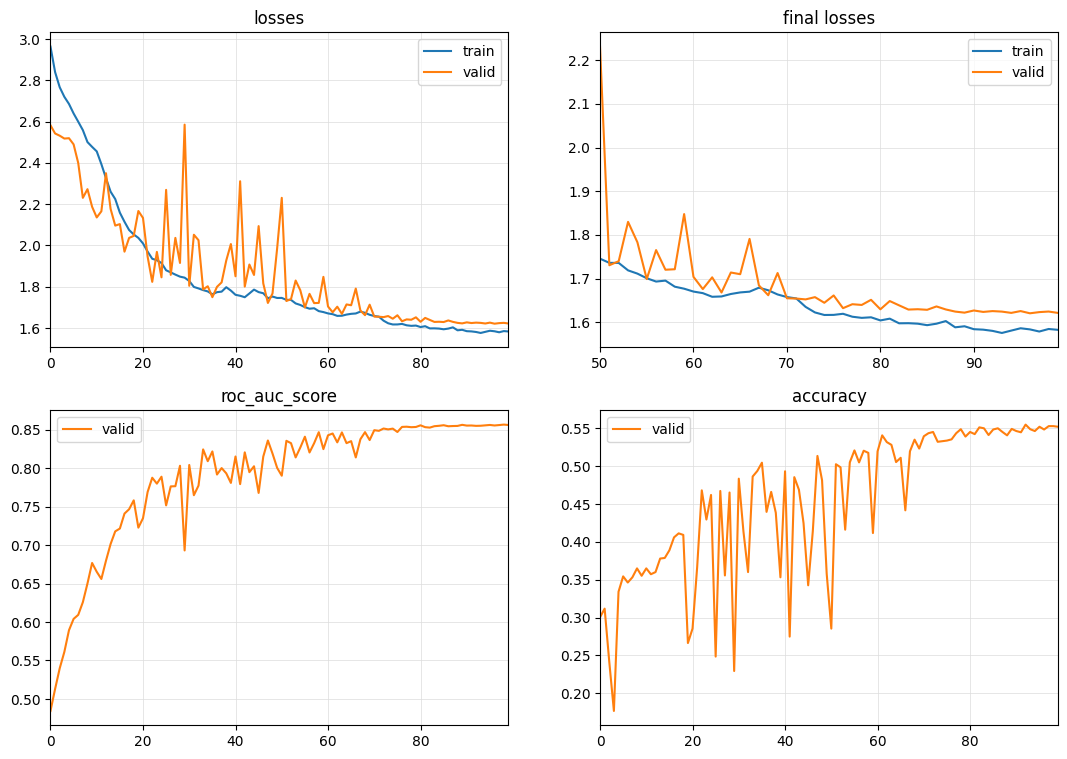


Elapsed time: 483.30079317092896


In [12]:
model = mWDNPlus(dls.vars, dls.c, dls.len, base_arch=TSTPlus, dropout=.3, fc_dropout=0.9)
#learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAuc(), accuracy],  cbs=ShowGraphCallback2())
learn.fit_one_cycle(n_epochs, sr.valley) 
print('\nElapsed time:', time.time() - start)

# Conclusion ✅